In [ ]:
!pip install scikit-plot

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!unzip fer2013_cleaned.zip

In [ ]:
!mkdir dataset
!mv 'Angry/' 'dataset/angry'
!mv 'Happy/' 'dataset/happy'
!mv 'Neutral/' 'dataset/neutral'
# !mv 'disgust/' 'dataset/disgust'
!mv 'fear/' 'dataset/fear'

mkdir: cannot create directory ‘dataset’: File exists


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('dataset', batch_size=32, image_size=(224, 224))
dataset.class_names

Found 16496 files belonging to 4 classes.


['angry', 'fear', 'happy', 'neutral']

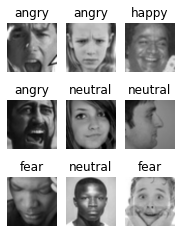

In [ ]:
plt.figure(figsize=(3,4))
class_names = dataset.class_names
for images, labels in dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# 528 in total
# 422 in training (80%)
# 53 in validation (10%)
# 53 in test (10%)

test_dataset = dataset.skip(422)
train_dataset = dataset.take(422)

validation_dataset = test_dataset.skip(47)
test_dataset = test_dataset.take(47)

# tf.data.experimental.cardinality(test_dataset).numpy()

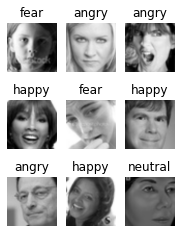

In [ ]:
images, labels = train_dataset.as_numpy_iterator().next()

plt.figure(figsize=(3, 4))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].astype("uint8"))
  plt.title(class_names[labels[i]])
  plt.axis("off")

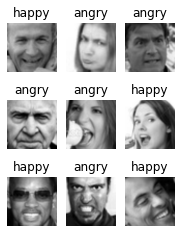

In [ ]:
images, labels = validation_dataset.as_numpy_iterator().next()

plt.figure(figsize=(3, 4))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].astype("uint8"))
  plt.title(class_names[labels[i]])
  plt.axis("off")

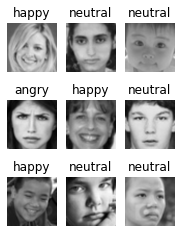

In [ ]:
images, labels = test_dataset.as_numpy_iterator().next()

plt.figure(figsize=(3, 4))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].astype("uint8"))
  plt.title(class_names[labels[i]])
  plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
IMG_SHAPE = (224, 224) + (3,)
base_model = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
norm_layer_1 = tf.keras.layers.BatchNormalization()
norm_layer_2 = tf.keras.layers.BatchNormalization()
norm_layer_3 = tf.keras.layers.BatchNormalization()
norm_layer_4 = tf.keras.layers.BatchNormalization()
prediction_layer_1 = tf.keras.layers.Dense(256, activation='relu')
prediction_layer_2 = tf.keras.layers.Dense(128, activation='relu')
prediction_layer_3 = tf.keras.layers.Dense(64, activation='relu')
prediction_layer_4 = tf.keras.layers.Dense(32, activation='relu')
prediction_layer_5 = tf.keras.layers.Dense(4, activation='softmax')

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(inputs)
x = global_average_layer(x)
x = prediction_layer_1(x)
x = norm_layer_1(x)
x = prediction_layer_2(x)
x = norm_layer_2(x)
x = prediction_layer_3(x)
x = norm_layer_3(x)
x = prediction_layer_4(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = norm_layer_4(x)
x = prediction_layer_5(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = x

model = tf.keras.Model(inputs, outputs)

In [ ]:
from tensorflow.python.training.saver import metrics
from tensorflow.keras.optimizers import Adam
optimizer = Adam()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 256)               147712    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                           

In [ ]:
hist = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=32,
    epochs=20)

Epoch 1/20
422/422 [==============================] - 36s 76ms/step - loss: 5.7827 - accuracy: 0.3702 - val_loss: 2.8514 - val_accuracy: 0.5625
Epoch 2/20
422/422 [==============================] - 30s 71ms/step - loss: 4.8615 - accuracy: 0.4154 - val_loss: 3.9779 - val_accuracy: 0.5759
Epoch 3/20
422/422 [==============================] - 30s 71ms/step - loss: 4.5708 - accuracy: 0.4244 - val_loss: 4.5594 - val_accuracy: 0.5813
Epoch 4/20
422/422 [==============================] - 30s 70ms/step - loss: 4.4792 - accuracy: 0.4218 - val_loss: 4.1934 - val_accuracy: 0.5974
Epoch 5/20
422/422 [==============================] - 30s 70ms/step - loss: 4.3268 - accuracy: 0.4316 - val_loss: 4.6268 - val_accuracy: 0.5934
Epoch 6/20
422/422 [==============================] - 30s 70ms/step - loss: 4.2508 - accuracy: 0.4348 - val_loss: 5.2888 - val_accuracy: 0.5739
Epoch 7/20
422/422 [==============================] - 30s 71ms/step - loss: 4.1827 - accuracy: 0.4363 - val_loss: 4.7084 - val_accuracy:

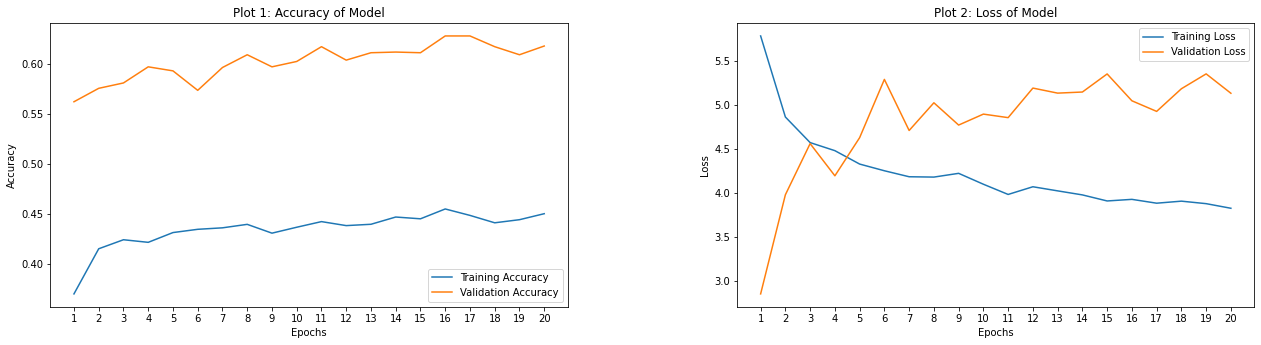

In [ ]:
import numpy as np

train_accs = hist.history['accuracy']
test_accs = hist.history['val_accuracy']
train_loss = hist.history['loss']
test_loss = hist.history['val_loss']
epoch_range = [x + 1 for x in range(len(train_accs))]

fig, ax = plt.subplots(1, 2)
fig.tight_layout(pad=2)
fig.set_size_inches(20, 5)

plt.subplot(1, 2, 1)
plt.plot(np.asarray(epoch_range).astype(str), train_accs, label='Training Accuracy')
plt.plot(np.asarray(epoch_range).astype(str), test_accs, label='Validation Accuracy')
plt.title('Plot 1: Accuracy of Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(np.asarray(epoch_range).astype(str), train_loss, label='Training Loss')
plt.plot(np.asarray(epoch_range).astype(str), test_loss, label='Validation Loss')
plt.title('Plot 2: Loss of Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.evaluate(test_dataset)

47/47 [==============================] - 11s 37ms/step - loss: 4.9986 - accuracy: 0.6356


[4.998571395874023, 0.6356382966041565]

[1 2 1 3 2 3 3 2 2 2 2 3 1 0 2 3 3 2 2 1 1 2 2 1 2 3 3 2 2 2 3 0]


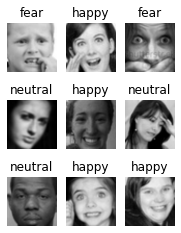

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = np.argmax(predictions, axis=1)
print(predictions)

plt.figure(figsize=(3, 4))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 35ms/step


In [ ]:
import sklearn.metrics
import scikitplot.metrics

print(sklearn.metrics.classification_report(correct_labels, predicted_labels))
print(class_names)

              precision    recall  f1-score   support

           0       0.55      0.23      0.32       256
           1       0.55      0.44      0.49       241
           2       0.68      0.86      0.76       617
           3       0.58      0.64      0.61       390

    accuracy                           0.63      1504
   macro avg       0.59      0.54      0.54      1504
weighted avg       0.61      0.63      0.60      1504

['angry', 'fear', 'happy', 'neutral']


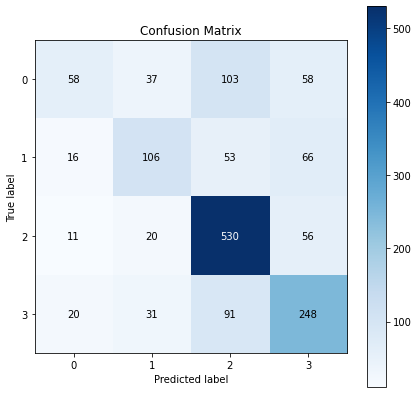

In [ ]:
scikitplot.metrics.plot_confusion_matrix(correct_labels, predicted_labels, figsize=(7,7))

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
!ls saved_model
!pwd

my_model
/content


In [ ]:
!zip -r saved_model/my_model .

Streaming output truncated to the last 5000 lines.
updating: dataset/neutral/Training_32294076.jpg (stored 0%)
updating: dataset/neutral/Training_60506833.jpg (stored 0%)
updating: dataset/neutral/Training_17461042.jpg (stored 0%)
updating: dataset/neutral/Training_47920998.jpg (stored 0%)
updating: dataset/neutral/Training_20846402.jpg (stored 0%)
updating: dataset/neutral/Training_66999154.jpg (stored 0%)
updating: dataset/neutral/Training_28701535.jpg (stored 0%)
updating: dataset/neutral/Training_15592879.jpg (stored 0%)
updating: dataset/neutral/Training_72384664.jpg (stored 0%)
updating: dataset/neutral/Training_93562523.jpg (stored 0%)
updating: dataset/neutral/Training_66496795.jpg (stored 0%)
updating: dataset/neutral/Training_22149828.jpg (stored 0%)
updating: dataset/neutral/Training_27652199.jpg (stored 0%)
updating: dataset/neutral/Training_48563863.jpg (stored 0%)
updating: dataset/neutral/Training_76282010.jpg (stored 0%)
updating: dataset/neutral/Training_38789618.jpg (